# Passenger and Plane Itinerary Optimization (PPIO) Problem
----

## Problem Description: 

For a given list of passengers with predefined origin airports and final destination airports, a fixed number of planes in operation, and a fixed network topology $G(A,R)$, we want to extract the optimal schedule or itinerary for each plane $p$ and each passenger $h$ throughout the day. 

This problem is related to the class of Traveling Salesman Problems, where the goal is to find the shortest distance path through cities such that the salesman starts and stops at the same city. The key differences in this optimization problem is that we are interested in minimizing the total travel time over each passenger $h$, and we have multiple agents traversing the network at scheduled times.

We will solve this optimization problem using a multi-integer linear programming approach. There are many applications of this optimization problem including logistics planning, energy management, crew scheduling, and telecommunications network design.

## PPIO Model Formulation:

### Sets and Indices
1. Airports, denoted by $A$. Capacity of airport, $K_a$
2. Passengers, denoted by $H$.
3. Aircrafts, denoted by $P$. Capacity of aircraft $p$ is denoted by $C_p$.
4. Discretized times, denoted by $T$. Total number of time periods will be denoted by $|T|$.
5. Flights, denoted by $F$. These are pairs $(e,t)$ of edges and starting times. A flight, $f$, is a possible plane going along $e$, with starting time $t$ (at the origin airport of $e$).

### Decision Variables
1. For every $h \in H$, $f \in F$, let $X_{h,f}=1$  if and only if human $h$ takes the flight $f$.
2. For every $p \in P$, $f \in F$,  let $Y_{p,f}=1$ if and only if aircraft $p$ flies flight $f$.
3. For every $t \in T$, $a \in A$, $h \in H$, let $Z_{t,h,a} = 1$ if and only if human $h$ is at airport $a$ at time $t$.
4. For every $t \in T$, $a \in A$, $p \in P$, let $W_{t,p,a} = 1$ if and only if aircraft $p$ is at airport $a$ (waiting) at time $t$.$

### Number of Decision Variables
- Define the complete graph of an airline's network as $G(A,E)$, where A ~ set of airports,|A| = n , E ~ all possible routes (i,j)
- Suppose $|H| = k, |F| = n(n-1)(T)$, then we have $n*(n-1)*T*k$ total $X_{h,f}$ variables
- Suppose $|P| = m$, then we have $n*(n-1)*T*m$ total $Y_{p,f}$ variables
- We have $T*k*n$ total $Z_{t,h,a}$ variables
- We have $T*n*m$ total $W_{t,p,a}$ variables
- Total: $n(n-1)(k)|T| + n(n-1)(m)|T| + (k)(n)|T| + (n)(m)|T|$


### Objective Function
**Minimum Total Travel Time**. Minimize the total travel time across all passengers. Each passenger $h$ is assigned an itinerary consisting of sequential $Z_{t,h,a}$ and $X_{h,f}$ variables.
\begin{equation}
\text{Min} \sum_{h} D_{h}
\tag{1}
\end{equation}

where the duration for a passenger $h \in H$ is the number of discretized time intervals between the first instance of departing from the origin airpor and the first instance of arriving at the ,

\begin{equation}
D_{h} = |T| - \sum_{t} Z_{t,h,orig(h)} - \sum_{t} Z_{t,h,dest(h)}
\tag{2}
\end{equation}

<font color="red">Note: All passengers start at their respective origin airport at time 0 and must reach their final destination airport by time T-1</font>

Define functions on $h$  (These will be fixed and defined when initializing variables)
1. $orig(h)$ = origin airport for passenger $h$
2. $dest(h)$ = final destination airport for passenger $h$

**Alternative Objective Function**

\begin{equation}
\text{Max} \sum_{h} \sum_{t} [Z_{t,h,orig(h)} + Z_{t,h,dest(h)}]
\tag{3}
\end{equation}


#### Constraints
1) **Starting Boundary Conditions**
   
   At $t=0$, all passengers $h \in H$ begin at the origin airport:

   \begin{equation}
   \forall h \in H, Z_{0,h,orig(h)} = 1
   \tag{4}
   \end{equation}


   At $t=0$, all planes $p \in P$ begin at some starting airport (let this be a random assignment):

   \begin{equation}
   \forall p \in P, W_{0,p,orig(p)} = 1
   \tag{5}
   \end{equation}


2) **Ending Boundary Conditions**

   At $t=|T|-1$, all passengers $h \in H$ end at their final destination airport:

   \begin{equation}
   \forall h \in H, Z_{|T|-1,h,dest(h)} = 1
   \tag{6}
   \end{equation}


   At $t=|T|-1$, all planes $p \in P$ must end at their starting airport:

   \begin{equation}
   \forall p \in P, W_{|T-1|,p,orig(p)} = 1
   \tag{7}
   \end{equation}

3) **Plane Capacity**

   Every plane $p$ has a passenger capacity: total capacity of all assigned planes or 0 if no planes is assigned to $f$:

   \begin{equation}
   \forall f \in F, \sum_{h} X_{h,f} \leq \sum_{p} C_{p} Y_{p,f}
   \tag{8}
   \end{equation}


4) **Airport Capacity**

   Every airport $a$ has a plane capacity: total capacity of all defined airports or 0 if no planes is assigned to $f$:

   \begin{equation}
   \forall a \in A, t \in T, \sum_{p} W_{t,p,a} \leq K_{a}
   \tag{9}
   \end{equation}
   

5) **Conflicting Flights for planes and passengers**

   A particulary plane $p$ cannot be assigned to more than one flight (at the exact same time $t$). For every pair of flights $f_{1}, f_{2}$, both of these flights cannot be serviced by the same plane $p$ because the time intervals for each $f$ intersect. 

   \begin{equation}
   \forall (f_{i}, f_{j}) \, \, \, Y_{p,f_{1}} + Y_{p,f_{2}} \leq 1
   \tag{8}
   \end{equation}

   For every passenger and pair of conflicting flights, $f_{1}, f_{2}$:

   \begin{equation}
   \forall (f_{i}, f_{j}), h \in H, \, \, \, X_{h,f_{1}} + X_{h,f_{2}} \leq 1
   \tag{9}
   \end{equation}

   The conficting flights, with respective to time $t$ is defined as:

   start($f_{1}$) $\leq$ start($f_{2}$) $\leq$ end($f_{1}$)    OR    start($f_{2}$) $\leq$ start($f_{1}$) $\leq$ end($f_{2}$)

6) **Conservation Laws for planes and passengers**

   A passenger at any given time $t$ must be either on a flight or waiting at an airport but they cannot be waiting at an airport or on a flight at the same time:

   \begin{equation}
   \forall h \in H, t \in T, \, \, \, \sum_{a} Z_{t,h,a} + \sum_{f: start(f) \leq t \leq end(f)} X_{h,f} = 1
   \tag{10}
   \end{equation}


   Similarly, a plane at any given time $t$ must be either operating a flight or waiting at an airport but they cannot be waiting at an airport or on a flight at the same time:

   \begin{equation}
   \forall p \in P, t \in T, \, \, \, \sum_{a} W_{t,p,a} + \sum_{f: start(f) \leq t \leq end(f)} Y_{p,f} = 1
   \tag{11}
   \end{equation}






7) **Continuity of Origin Airport**
   
   For every plane $p$ and flight $f$, the plane must be at the origin airport of the flight before the start time of $f$:

   \begin{equation}
   \forall p \in P, f \in F \, \, \, \,  W_{start(f) - 1, p, orig(f)} \geq Y_{p,f}
   \tag{12}
   \end{equation}

   This constraint ensures that if a plane is operating route $f$ then that means it must have been waiting at the origin airport of $f$ at the time right before  (both binary variables are stored as 1). 

   This same continuity principle exists for passengers $h \in H$. If a passenger is on some flight $f$, then they must have been waiting at the corresponding origin airport at a time $t-1$:

   \begin{equation}
   \forall h \in H, f \in F \, \, \, Z_{start(f) - 1, h, orig(f)} \geq X_{h,f}
   \tag{13}
   \end{equation}

8) **Continuity of Destination Airport**

    Similar to the previous constraint but now in the opposite direction. For every plane $p$ and flight $f$, the plane must be at the destination airport of the flight after the end time of the flight. For every plane $p$, time $t$, and airport $a$, if $W_{t,p,a} = 1$, then it must have been at that airport or a flight was flown there (just arrived):

    \begin{equation}
    \forall p \in P, t \in T , a \in A \, \, \, \,  W_{t - 1, p, a} + \sum_{f: dest(f)=a, end(f)=t-1} Y_{p,f} \geq W_{t,p,a}
    \tag{14}
    \end{equation}

    Similarly, the continuity principle exists for all passengers through the network:

    \begin{equation}
    \forall h \in H, t \in T , a \in A \, \, \, \,  Z_{t - 1, h, a} + \sum_{f: dest(f)=a, end(f)=t-1} X_{h,f} \geq Z_{t,h,a}
    \tag{15}
    \end{equation}

In [1]:
# import packages
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm 
import folium
import json
import os
from folium import plugins
import gurobipy as gp
import random
import itertools
import math
from gurobipy import GRB
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preprocessing

Large-scale Air Traffic and Passenger Data
1. Considering only domestic US air travel
2. ~5,000 total US airports
3. ~45,000 daily domestic flights in the US
4. 1.73 million passengers transported daily

Sample Passenger Demand Data
1. We have passenger data extracted from BTS (Bureau of Transportation Statistics)
2. This passenger table contains a the variable h indexed by integers: $[h_{1}, h_{2}, . . . ]$
3. The origin and destination functions are applied to each passenger $h_{i}$ and are assigned to the two respective columns

In [2]:

def plane_capacity(planes, mean, std, min_h, max_h):
    '''
    Goal: Return passenger capacities for each unique plane:
            This depends on the type of aircraft, amount of cargo, etc 
            We use a uniform distribution over the supports [min h, max h]   
    Parameters:
        planes: (list) list of planes in operation over the network  (defined as string indices)
        mean: (float) the mean passenger capacity over all planes
        std: (float) the stdev of passenger capacity over all planes
        min_h: (int) the minimum number of passengers allowed on a plane
        max_h: (int) the maximum number of passengers allowed on a plane
    Returns:
        capacity_p: (dict) a dictionary of keys as planes with associated passenger capacity
    ''' 

    # define capacity of each plane
    # src: https://www.faa.gov/sites/faa.gov/files/regulations_policies/policy_guidance/benefit_cost/econ-value-section-3-capacity.pdf  
    capacity_p = {}
    # define distribution for plane capacity 
    # truncated normal distribution  (support: {85, 215}) with mean 150 and stdev 80
    a, b = (min_h - mean) / std, (max_h - mean) / std
    for i in planes:
        capacity_p[i] = int(truncnorm.rvs(a, b, loc = mean, scale = std, size=1))
    return capacity_p

def airport_capacity(airports, mean, std, min_a, max_a):
    '''
    Goal: Return planes capacities for each unique airport:
            This depends on the type of airport, amount of cargo, etc 
            We use a uniform distribution over the supports [min a, max a]   
    Parameters:
        airports: (list) list of airports in operation over the network  (defined as string indices)
        mean: (float) the mean plane capacity over all airports
        std: (float) the stdev of plane capacity over all airports
        min_a: (int) the minimum number of planes allowed on a plane
        max_a: (int) the maximum number of planes allowed on a plane
    Returns:
        capacity_a: (dict) a dictionary of keys as airports with associated plane capacity
    '''
    # define capacity of each airport
    capacity_a = {}
    # define distribution for airport capacity 
    # truncated normal distribution  (support: {1, 5}) with mean and stdev
    a, b = (min_a - mean) / std, (max_a - mean) / std
    for i in airports:
        capacity_a[i] = int(truncnorm.rvs(a, b, loc = mean, scale = std, size=1))
    return capacity_a

def create_complete_network(airports):
    '''
    Goal: given a set of airports to serve as nodes of the graph, return a complete airline network topology
    Parameters:
        airports (list): list of airports in the network
    Return:
        G_complete (networkx graph): the complete graph of the airline network topology
    '''
    # consider a complete graph (all possible options)
    G_complete = nx.complete_graph(airports) # we select flights (t + route(i,j)) to operate these   (a flight object is later defined)
    coords = {}
    for i in G_complete.nodes:
        origin_lat = float(airports_data.loc[airports_data['local_code'] == i]['latitude_deg'].values)
        origin_long = float(airports_data.loc[airports_data['local_code'] == i]['longitude_deg'].values)
        coords[i] = (origin_lat, origin_long)
    nx.set_node_attributes(G_complete, coords, name = 'pos')
    G_complete = G_complete.to_directed()
    return G_complete

def sample_routes(set_of_airports, total_edges):
    '''
    Goal: generate a random subset of directed edges / routes from the complete graph
    Parameters:
        set_of_airports (list): a list of airports in the airline network topology
        total_edge (int): number of routes to sample from complete graph
    Return:
        sampled_routes (list): list of viable routes in the network such that a path exists between all airports
    '''
    def is_connected(random_routes):
        permutations_of_routes = list(itertools.permutations(set_of_airports, 2))
        # ensure the random routes generated forms a connected graph!
        G_check = nx.DiGraph()
        # Add edges from the list of tuples
        G_check.add_edges_from(random_routes)

        for pair in permutations_of_routes:
            if not nx.has_path(G_check, pair[0], pair[1]):
                return False
        return True

    permutations_of_routes = list(itertools.permutations(set_of_airports, 2))
    condition = False
    while not condition:
        sampled_routes = random.sample(permutations_of_routes, total_edges)
        condition = is_connected(sampled_routes)
    return sampled_routes

# DATA: airports IATA Code and Geographical Coordinates
airports_data = pd.read_csv('Data/us-airports.csv')
airports_data = airports_data[['latitude_deg','longitude_deg','local_code']]
airports_data = airports_data.iloc[1:]

# DATA: on time preformance by airlines between two airports : extract distance and duration
us_ontime_market = pd.read_csv('Data/T_ONTIME_MARKETING.csv')
us_ontime_market = us_ontime_market.groupby(['ORIGIN', 'DEST'])[['ACTUAL_ELAPSED_TIME', 'DISTANCE']].mean().reset_index()

### Complete Airline Network Topology Example

In [3]:
airports_ex = ['EWR','PDX','LAX','SFO','SEA','DEN','ORD','MIA','MCO','DFW'] 
# Create a map centered around the US
m = folium.Map(location=[39.8283, -98.5795], zoom_start=5)
G = create_complete_network(airports_ex)
# Iterate through the nodes and add markers for each airport
coords = nx.get_node_attributes(G, "pos")
for node in G.nodes:
    lat, lon = nx.get_node_attributes(G, 'pos')[node]
    folium.Marker(location=[lat, lon], popup=node).add_to(m)
# Iterate through the edges and draw lines connecting airports
for u, v in G.edges():
    lat1, lon1 = G.nodes[u]["pos"]
    lat2, lon2 = G.nodes[v]["pos"]
    folium.PolyLine([(lat1, lon1), (lat2, lon2)], color="blue").add_to(m)

In [4]:
class Passenger:
    # Define a passenger object to represent all human passengers traversing the airline network
    def __init__(self, origin, destination):
        self.origin = origin
        self.destination = destination
    def get_origin(self):
        return self.origin
    def get_destination(self):
        return self.destination
    def __repr__(self):
        return f"Passenger traveling from {self.origin} to {self.destination}"
    
# define an object called Flight which consists of a 2-tuple of the route 
# serviced (consisting or origin and destination) airport code and the time t of departure.
class Flight:
    def __init__(self, origin, destination, departure_time, duration=None):
        self.origin = origin
        self.destination = destination
        self.departure_time = departure_time
        self.origin_lat = float(airports_data.loc[airports_data['local_code'] == origin]['latitude_deg'].values)
        self.origin_long = float(airports_data.loc[airports_data['local_code'] == origin]['longitude_deg'].values)
        self.dest_lat = float(airports_data.loc[airports_data['local_code'] == destination]['latitude_deg'].values)
        self.dest_long = float(airports_data.loc[airports_data['local_code'] == destination]['longitude_deg'].values)
        #self.duration = duration or self.get_flight_duration()
        
    def get_origin(self):
        return self.origin

    def get_destination(self):
        return self.destination
        
    def get_departure_time(self):
        return self.departure_time

    def get_fight_duration(self):
        filtrd_data = us_ontime_market[(us_ontime_market['ORIGIN'] == self.origin) & (us_ontime_market['DEST'] == self.destination)]
        flight_duration = int(filtrd_data['ACTUAL_ELAPSED_TIME'].values[0])
        return flight_duration

    def get_arrival_time(self):
        return int(np.ceil(self.get_fight_duration()/60)) + self.departure_time

    def get_distance(self):
        # Radius of the Earth in miles
        earth_radius = 3958.8
        # Convert latitude and longitude from degrees to radians
        lat1, lon1, lat2, lon2 = map(math.radians, [self.origin_lat, self.origin_long, self.dest_lat, self.dest_long])
        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = earth_radius * c
        distance = us_ontime_market[(us_ontime_market['ORIGIN'] == self.origin) & (us_ontime_market['DEST'] == self.destination)]['DISTANCE']
        return distance 

    def visualize_route(self):
        m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
        folium.Marker(location=[self.origin_lat, self.origin_long], popup=node).add_to(m)
        folium.Marker(location=[self.dest_lat, self.dest_long], popup=node).add_to(m)
        folium.PolyLine([(self.origin_lat, self.origin_long), (self.dest_lat, self.dest_long)], color="blue").add_to(m)
        return m

    def __repr__(self):
        return f"Flight from {self.origin} to {self.destination} departing at t = {self.departure_time}, and arriving at t = {self.get_arrival_time()}"

## Experiment 1:
### Define all Decision Variables and load into Gurobi
1. T: 18 time increments 
2. 6 airports
3. 4 planes
4. 10 passengers
5. 10 possible routes

- Total: $n(n-1)(k)|T| + n(n-1)(m)|T| + (k)(n)|T| + (n)(m)|T|$

Total number of decision variables: (10)(10)(18) + (10)(4)(18) + (10)(6)(18) + (6)(4)(18) = 4032 binary variables

In [8]:
# define Time -  Assume a 18 hour period decritized by time intervals by the minute 
T = np.arange(0, 12, 1)

# define airports
set_of_airports = ['BWI', 'LAX', 'ORD']
N = len(set_of_airports)

# define possible routes
routes = sample_routes(set_of_airports, 4)
permutations_of_routes = list(itertools.permutations(set_of_airports, 2))

# define the set of planes and P number of planes to use
P = 2
planes_p = {}
for x in range(P):
    planes_p[f"p_{x}"] = random.sample(set_of_airports,1)[0]


# Define capacities for airport, plane
capacity_p = plane_capacity(planes_p, 4, 3, 1, 8)
capacity_a = airport_capacity(set_of_airports, 5, 2, 5, 10)

# define a list of passengers (we have 10 passengers)
H = 5
passengers_h = {}
for i in range(H):
    # define a random origin and final destination airport for each passenger
    origin_h, dest_h = random.sample(permutations_of_routes, 1)[0]
    passengers_h[f'''h_{i}'''] = Passenger(origin_h, dest_h)

# define flights given all possible routes and time t
# define all possible flights: this is dependent on the time AND route 
flights = {}
counter = 1
for i in routes:
    for t in T:
        name = f'''f_{counter}'''
        org, dest = i
        flight_obj = Flight(origin=org, destination=dest, departure_time=t)
        flights[name] = (flight_obj.get_origin(), flight_obj.get_destination(), flight_obj.get_departure_time(), flight_obj.get_arrival_time())
        counter += 1

**Sample Fixed Data**

In [5]:
routes = [('ORD', 'LAX'), ('BWI', 'ORD'), ('LAX', 'BWI'), ('BWI','LAX')]
T = np.arange(0, 24, 1)

set_of_airports = ['BWI', 'LAX', 'ORD']
planes_p = {'p_0': 'ORD', 'p_1': 'LAX'}

N = len(set_of_airports)

capacity_p = plane_capacity(planes_p, 100, 3, 1, 800)
capacity_a = airport_capacity(set_of_airports, 50, 2, 5, 100)


permutations_of_routes = list(itertools.permutations(set_of_airports, 2))

H = 5
passengers_h = {'h_0': Passenger('BWI','ORD'),  'h_1': Passenger('LAX','ORD'), 
                'h_2': Passenger('ORD','LAX'), 'h_3': Passenger('ORD','LAX'), 
                'h_4': Passenger('ORD','LAX')}

flights = {}
counter = 1
for org, dest in routes:
    for t in T:
        name = f'''f_{counter}'''
        flight_obj = Flight(origin=org, destination=dest, departure_time=t)
        flights[name] = (flight_obj.get_origin(), flight_obj.get_destination(), flight_obj.get_departure_time(), flight_obj.get_arrival_time())
        counter += 1

In [6]:
# Create a Gurobi model
m = gp.Model("Flight_Optimization")


# Create a dictionary to hold the decision variables X[f, h] for each combination of flight and passenger
X_inds = []
for f in flights:
    for h in passengers_h.keys():
        index = (flights[f], h)
        X_inds.append(index)
X_vars = m.addVars(X_inds, vtype=GRB.BINARY, name='X')


# create a dictionary to hold the decision variable Y[p,f] for each combination of plane and flight
Y_inds = []
for p in planes_p.keys():
    for f in flights:
        index = (p, flights[f])
        Y_inds.append(index)
Y_vars = m.addVars(Y_inds, vtype=GRB.BINARY, name='Y')


# create a dictionary to hold the decision variable W[t,p,a] for each combination of time, airport, plane
W_inds = []
for t in T:
    for p in planes_p.keys():
        for a in set_of_airports:
            W_inds.append((t,p,a))
W_vars = m.addVars(W_inds, vtype=GRB.BINARY, name='W')
       

# create a dictionary to hold the decision variable Z[t,h,a] for each combination of time, passenger, airport
Z_inds = []
for t in T:
    for h in passengers_h.keys():
        for a in set_of_airports:
            Z_inds.append((t,h,a))
Z_vars = m.addVars(Z_inds, vtype=GRB.BINARY, name='Z')

m.update()
print('Model Updated with Decision Vars')


# Add the objective function to the model

# Define the objective expression
objective_expr = gp.quicksum(Z_vars[(t, h, passengers_h[h].get_origin())] + 
                             Z_vars[(t, h, passengers_h[h].get_destination())] 
                             for t in T for h in passengers_h.keys())

# Set the objective function to maximize the above expression
m.setObjective(objective_expr, GRB.MAXIMIZE)
m.update()
print('Model Updated with Core Objective Function')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-07
Model Updated with Decision Vars
Model Updated with Core Objective Function


In [7]:
# Add General boundary conditions to the gurobi model m
# first add boundary for location of each plane p

# Define the starting boundary conditions at t=0 for passengers
for h in passengers_h.keys():
    m.addConstr(Z_vars[(0, h, passengers_h[h].get_origin() )] == 1, name=f'StartingBoundaryPassenger_{h}')

# Define the starting boundary conditions at t=0 for planes (random assignment)
for p in planes_p.keys():
    m.addConstr(W_vars[(0, p, planes_p[p] )] == 1, name=f'StartingBoundaryPlane_{p}')

# Define the ending boundary conditions at t=|T|-1 for passengers
for h in passengers_h.keys():
    m.addConstr(Z_vars[(len(T) - 1, h, passengers_h[h].get_destination() )] == 1, name=f'EndingBoundaryPassenger_{h}')

# Define the ending boundary conditions at t=|T|-1 for planes
for p in planes_p:
    m.addConstr(W_vars[(len(T) - 1, p,  planes_p[p] )] == 1, name=f'EndingBoundaryPlane_{p}')

# Define Airport Capacity constraint (Constraint 9)
for t in T:
    for a in set_of_airports:
        m.addConstr(gp.quicksum(W_vars[t, p, a] for p in planes_p) <= capacity_a[a],
                    name=f'AirportCapacity_{t}_{a}')
        
# Define Plane Capacity constraint (Constraint 8)
for f in flights:
    m.addConstr(gp.quicksum(X_vars[flights[f], h] for h in passengers_h.keys()) <=
                gp.quicksum(capacity_p[p] * Y_vars[p, flights[f]] for p in planes_p),
                name=f'PlaneCapacity_{f}')
    

def conflicting_flights(f1,f2):
    # return true if f1 and f2 form a conflicting flight 
    start_f1 = flights[f1][2]
    end_f1 = flights[f1][3]
    start_f2 = flights[f2][2]
    end_f2 = flights[f2][3]
    return start_f1 <= start_f2 <= end_f1 or start_f2 <= start_f1 <= end_f2
      
# Define Conflicting Flights for planes (Constraint 8)
for p in planes_p:
    for f1 in flights:
        for f2 in flights:
            if f1 != f2 and conflicting_flights(f1, f2):
                m.addConstr(Y_vars[p, flights[f1]] + Y_vars[p, flights[f2]] <= 1, name=f'PlaneConflict_{p}_{f1}_{f2}')

# Define Conflicting Flights for passengers (Constraint 9)
for h in passengers_h.keys():
    for f1 in flights:
        for f2 in flights:
            if f1 != f2 and conflicting_flights(f1, f2):
                m.addConstr(X_vars[flights[f1], h] + X_vars[flights[f2], h] <= 1, name=f'PassengerConflict_{h}_{f1}_{f2}')


# Define Conservation Laws for passengers (Constraint 10)
for h in passengers_h.keys():
    for t in T:
        m.addConstr(gp.quicksum(Z_vars[(t, h, a)] for a in set_of_airports) +
                     gp.quicksum(X_vars[flights[f], h] for f in flights if flights[f][2] <= t <=  flights[f][3]  ) == 1,
                     name=f'PassengerConservation_{h}_{t}')

# Define Conservation Laws for planes (Constraint 11)
for p in planes_p:
    for t in T:
        m.addConstr(gp.quicksum(W_vars[(t, p, a)] for a in set_of_airports) +
                     gp.quicksum(Y_vars[p, flights[f]] for f in flights if flights[f][2] <= t <= flights[f][3]) == 1,
                     name=f'PlaneConservation_{p}_{t}')


# Define Continuity of Origin Airport for planes (Constraint 12)
for p in planes_p:
    for f in flights:
        if flights[f][2] > 0:  # Exclude t=0
            m.addConstr(W_vars[flights[f][2] - 1, p, flights[f][0]] >= Y_vars[p, flights[f]], name=f'PlaneOriginContinuity_{p}_{f}')
# Define Continuity of Origin Airport for passengers (Constraint 13)
for h in passengers_h.keys():
    for f in flights:
        if flights[f][2] > 0:  # Exclude t=0
            m.addConstr(Z_vars[flights[f][2] - 1, h, flights[f][0]] >= X_vars[flights[f], h], name=f'PassengerOriginContinuity_{h}_{f}')


# Define Continuity of Destination Airport for planes (Constraint 14)
for p in planes_p:
    for t in T:
        for a in set_of_airports:
            if t > 0:  # Exclude t=0
                m.addConstr(W_vars[t - 1, p, a] +
                             gp.quicksum(Y_vars[p, flights[f]] 
                                         for f in flights 
                                            if flights[f][1] == a and flights[f][3] == t - 1) >= W_vars[t, p, a],
                             name=f'PlaneDestinationContinuity_{p}_{t}_{a}')

# Define Continuity of Destination Airport for passengers (Constraint 15)
for h in passengers_h.keys():
    for t in T:
        for a in set_of_airports:
            if t > 0:  # Exclude t=0
                m.addConstr(Z_vars[t - 1, h, a] +
                             gp.quicksum(X_vars[flights[f], h] 
                                         for f in flights 
                                            if  flights[f][1] == a and flights[f][3] == t - 1) >= Z_vars[t, h, a],
                             name=f'PassengerDestinationContinuity_{h}_{t}_{a}')

In [8]:
m.update()
print('Model updated with all constraints')
## run the model
m.optimize()

Model updated with all constraints
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 25837 rows, 1176 columns and 56284 nonzeros
Model fingerprint: 0xdd4bb7bc
Variable types: 0 continuous, 1176 integer (1176 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]


Presolve removed 25601 rows and 981 columns
Presolve time: 0.11s
Presolved: 236 rows, 195 columns, 1040 nonzeros
Variable types: 0 continuous, 195 integer (195 binary)
Found heuristic solution: objective 87.0000000

Root relaxation: cutoff, 107 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0        87.00000   87.00000  0.00%     -    0s

Explored 1 nodes (107 simplex iterations) in 0.19 seconds (0.05 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 87 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.700000000000e+01, best bound 8.700000000000e+01, gap 0.0000%


In [92]:
# extract the iterinary for a passenger during T times

def extract_passenger_initinary(h):
    # List to store variables with value 1
    z_1_vars = []

    # Iterate through the dictionary
    for key, gurobi_var in Z_vars.items():
        # Check if the value of the Gurobi variable is equal to 1
        if gurobi_var.X >= 0.5:
            z_1_vars.append(key)

    # List to store variables with value 1
    x_1_vars = []

    # Iterate through the dictionary
    for key, gurobi_var in X_vars.items():
        # Check if the value of the Gurobi variable is equal to 1
        if gurobi_var.X >= 0.5:
            x_1_vars.append(key)

    # extract all passenger h data
    passenger_vars_x = [var for var in x_1_vars if var[1] == h]
    passenger_vars_z = [var for var in z_1_vars if var[1] == h]

    events = {}
    # Process the first list
    for i in range(len(passenger_vars_z) - 1):
        start_time = passenger_vars_z[i][0]
        end_time = passenger_vars_z[i][0] + 1
        airport = passenger_vars_z[i][2]
        events[f'{airport}_{i}'] = {'start': start_time, 'end': end_time, 'label': airport}
    # Process the second list
    for flight_info, passenger in passenger_vars_x:
        start_airport, end_airport, start_time22, end_time22 = flight_info
        flight_label = f'{start_airport} -> {end_airport}'
        events[f'{flight_label}'] = {'start': start_time22, 'end': end_time22 + 1, 'label': f'{start_airport} -> {end_airport}'}
    # Create a dictionary to store the merged events
    merged_events = {}

    # Iterate through the events data
    for event_id, event_info in events.items():
        label = event_info['label']
        
        # Check if the label is already in the merged events dictionary
        if label in merged_events:
            # If yes, update the end time of the existing event
            merged_events[label]['end'] = event_info['end']
        else:
            # If not, add a new entry to the merged events dictionary
            merged_events[label] = {'start': event_info['start'], 'end': event_info['end'], 'label': label}

    # Print the merged events
    for label, event_info in merged_events.items():
        print(f"Event: {label}, Start: {event_info['start']}, End: {event_info['end']}")
    events = merged_events

    fig_1 = plt.figure(figsize = (15,2), facecolor='w',edgecolor='k')

    # Plot each interval on the timeline
    for event, data in merged_events.items():
        start = data['start']
        end = data['end']
        plt.plot([start, end], [0, 0], label=event, linewidth=8)

    # Add labels above the intervals with arrows
    for event, data in merged_events.items():
        start = data['start']
        end = data['end']
        label_x = (start + end) / 2  # Center the label
        label_y = 0.005  # Height above the timeline
        plt.annotate(event, xy=(label_x, label_y), xytext=(label_x, label_y + 0.02),
                    arrowprops=dict(facecolor='black', arrowstyle='wedge,tail_width=0.7', lw=1),
                    ha='center', va='bottom', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

    # Customize the plot
    plt.yticks([])  # Hide y-axis ticks
    plt.xlabel('Time')
    plt.title(f'''Itinerary  for Passenger {h}''')
    plt.show()    

Event: LAX, Start: 0, End: 10
Event: BWI, Start: 16, End: 17
Event: ORD, Start: 21, End: 23
Event: BWI -> ORD, Start: 17, End: 21
Event: LAX -> BWI, Start: 10, End: 16


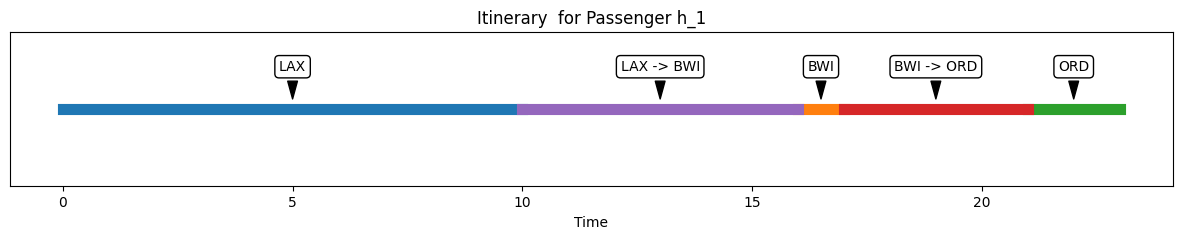

In [94]:
extract_passenger_initinary('h_1')

In [88]:
w_1_vars = []

# Iterate through the dictionary
for key, gurobi_var in W_vars.items():
    # Check if the value of the Gurobi variable is equal to 1
    if gurobi_var.X >= 0.5:
        w_1_vars.append(key)


# List to store variables with value 1
y_1_vars = []

# Iterate through the dictionary
for key, gurobi_var in Y_vars.items():
    # Check if the value of the Gurobi variable is equal to 1
    if gurobi_var.X >= 0.5:
        y_1_vars.append(key)

In [89]:
# extract all passenger h data
passenger_vars_w = [var for var in w_1_vars if var[1] == h]
passenger_vars_y = [var for var in y_1_vars if var[1] == h]

In [ ]:
# extract the iterinary for a passenger during T times

def extract_plane_initinary(h):
    # List to store variables with value 1
    w_1_vars = []

    # Iterate through the dictionary
    for key, gurobi_var in W_vars.items():
        # Check if the value of the Gurobi variable is equal to 1
        if gurobi_var.X >= 0.5:
            w_1_vars.append(key)


    # List to store variables with value 1
    y_1_vars = []

    # Iterate through the dictionary
    for key, gurobi_var in Y_vars.items():
        # Check if the value of the Gurobi variable is equal to 1
        if gurobi_var.X >= 0.5:
            y_1_vars.append(key)
    # extract all passenger h data
    passenger_vars_w = [var for var in w_1_vars if var[1] == h]
    passenger_vars_y = [var for var in y_1_vars if var[1] == h]

    

    events = {}
    # Process the first list
    for i in range(len(passenger_vars_z) - 1):
        start_time = passenger_vars_z[i][0]
        end_time = passenger_vars_z[i][0] + 1
        airport = passenger_vars_z[i][2]
        events[f'{airport}_{i}'] = {'start': start_time, 'end': end_time, 'label': airport}
    # Process the second list
    for flight_info, passenger in passenger_vars_x:
        start_airport, end_airport, start_time22, end_time22 = flight_info
        flight_label = f'{start_airport} -> {end_airport}'
        events[f'{flight_label}'] = {'start': start_time22, 'end': end_time22 + 1, 'label': f'{start_airport} -> {end_airport}'}
    # Create a dictionary to store the merged events
    merged_events = {}

    # Iterate through the events data
    for event_id, event_info in events.items():
        label = event_info['label']
        
        # Check if the label is already in the merged events dictionary
        if label in merged_events:
            # If yes, update the end time of the existing event
            merged_events[label]['end'] = event_info['end']
        else:
            # If not, add a new entry to the merged events dictionary
            merged_events[label] = {'start': event_info['start'], 'end': event_info['end'], 'label': label}

    # Print the merged events
    for label, event_info in merged_events.items():
        print(f"Event: {label}, Start: {event_info['start']}, End: {event_info['end']}")
    events = merged_events

    fig_1 = plt.figure(figsize = (15,2), facecolor='w',edgecolor='k')

    # Plot each interval on the timeline
    for event, data in merged_events.items():
        start = data['start']
        end = data['end']
        plt.plot([start, end], [0, 0], label=event, linewidth=8)

    # Add labels above the intervals with arrows
    for event, data in merged_events.items():
        start = data['start']
        end = data['end']
        label_x = (start + end) / 2  # Center the label
        label_y = 0.005  # Height above the timeline
        plt.annotate(event, xy=(label_x, label_y), xytext=(label_x, label_y + 0.02),
                    arrowprops=dict(facecolor='black', arrowstyle='wedge,tail_width=0.7', lw=1),
                    ha='center', va='bottom', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

    # Customize the plot
    plt.yticks([])  # Hide y-axis ticks
    plt.xlabel('Time')
    plt.title('Itinerary  for Passenger h_1')
    plt.show()    

In [ ]:
# function takes in a time stamp and returns positions of each plane

